In [6]:
import numpy as np
import pandas as pd

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from PIL import Image

def create_df_by_classes(base_path, classes, img_limit=1000):

    dd = {"images": [], "labels": []}

    for class_name in classes:
        img_dir = os.path.join(base_path, class_name)
        if not os.path.exists(img_dir):
            print(f"Warning: Folder {img_dir} does not exist, skipping.")
            continue

        for index, filename in enumerate(os.listdir(img_dir)):
            if index >= img_limit:  # limit to img_limit images per class
                break
            dd["images"].append(os.path.join(img_dir, filename))
            dd["labels"].append(class_name)

    return pd.DataFrame(dd)

classes = ["Angry", "Fear", "Happy", "Sad", "Surprise"]
df = create_df_by_classes("../EmotionsArchive/Data", classes)

index_label = dict()
label_index = dict()

for i, j in enumerate(df["labels"].unique()):
    index_label[i] = j
    label_index[j] = i

df["labels"] = df["labels"].map(label_index)

df = df.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe

In [7]:
df.head()

,images,labels
0,../EmotionsArchive/Data\Angry\10968269.png,0
1,../EmotionsArchive/Data\Happy\11242.png,2
2,../EmotionsArchive/Data\Happy\10697.png,2
3,../EmotionsArchive/Data\Fear\11767.png,1
4,../EmotionsArchive/Data\Angry\1270874.png,0


In [8]:
EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 224
BATCH = 16
OUT_SIZE = len(index_label)

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        
        img, label = self.data[x, 0], self.data[x, 1]

        img = Image.open(img).convert("RGB")
        img = np.array(img)

        img = self.transform(img)
        return img, label

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train, val = train_test_split(df.values, random_state=42, test_size=0.2)
val, test = train_test_split(val, random_state=42, test_size=0.5)

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Epoch 1 train loss 0.09564338940382004 acc 0.33825 val loss 0.09456626486778259 acc 0.422
Epoch 2 train loss 0.08847648358345031 acc 0.475 val loss 0.0922494466304779 acc 0.452
Epoch 3 train loss 0.08495803245902062 acc 0.5375 val loss 0.09081980419158936 acc 0.464
Epoch 4 train loss 0.08253922659158706 acc 0.57575 val loss 0.08790722036361695 acc 0.53
Epoch 5 train loss 0.0801843149960041 acc 0.617 val loss 0.08616276168823242 acc 0.568
Epoch 6 train loss 0.07805738100409508 acc 0.653 val loss 0.08746505928039551 acc 0.538
Epoch 7 train loss 0.07637727436423301 acc 0.6795 val loss 0.08649940228462219 acc 0.536
Epoch 8 train loss 0.07419381694495678 acc 0.7135 val loss 0.0831476435661316 acc 0.592
Epoch 9 train loss 0.07191142816841602 acc 0.7545 val loss 0.08344223308563233 acc 0.588
Epoch 10 train loss 0.07049462722241878 acc 0.77575 val loss 0.08930557298660279 acc 0.506


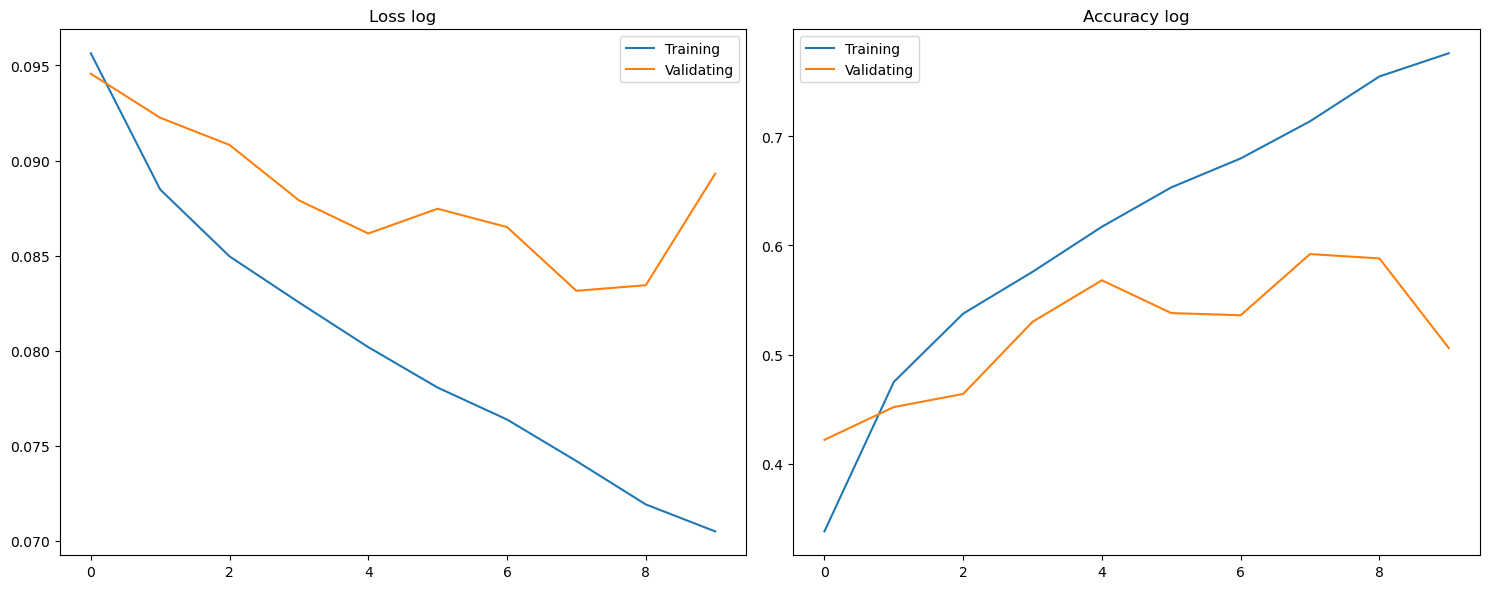

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].set_title("Loss log")
axes[index].legend()

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].set_title("Accuracy log")
axes[index].legend()
plt.tight_layout()
plt.show()